In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Reading the Data

In [2]:
data_dir = '/kaggle/input/5-flower-types-classification-dataset/flower_images'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
df

,filepaths,labels
0,/kaggle/input/5-flower-types-classification-da...,Orchid
1,/kaggle/input/5-flower-types-classification-da...,Orchid
2,/kaggle/input/5-flower-types-classification-da...,Orchid
3,/kaggle/input/5-flower-types-classification-da...,Orchid
4,/kaggle/input/5-flower-types-classification-da...,Orchid
...,...,...
4995,/kaggle/input/5-flower-types-classification-da...,Lilly
4996,/kaggle/input/5-flower-types-classification-da...,Lilly
4997,/kaggle/input/5-flower-types-classification-da...,Lilly
4998,/kaggle/input/5-flower-types-classification-da...,Lilly


# Visualizing 

In [4]:
lilly=plt.imread(df.loc[4995,'filepaths'])

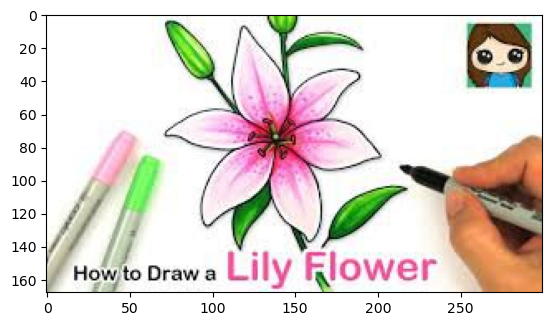

In [5]:
plt.imshow(lilly)

In [6]:
lilly.max()

255

In [7]:
lilly.min()

0

In [8]:
lilly.shape

(168, 300, 3)

# Splitting the data into Train, Test and Validation

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [11]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
#Augmenting the images using ImageDataGenerator
train_gen = ImageDataGenerator( 
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest')
test_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()


In [12]:
train_gen = train_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', 
                                          target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', 
                                        target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

testing_gen = test_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', 
                                           target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4000 validated image filenames belonging to 5 classes.
Found 600 validated image filenames belonging to 5 classes.
Found 400 validated image filenames belonging to 5 classes.


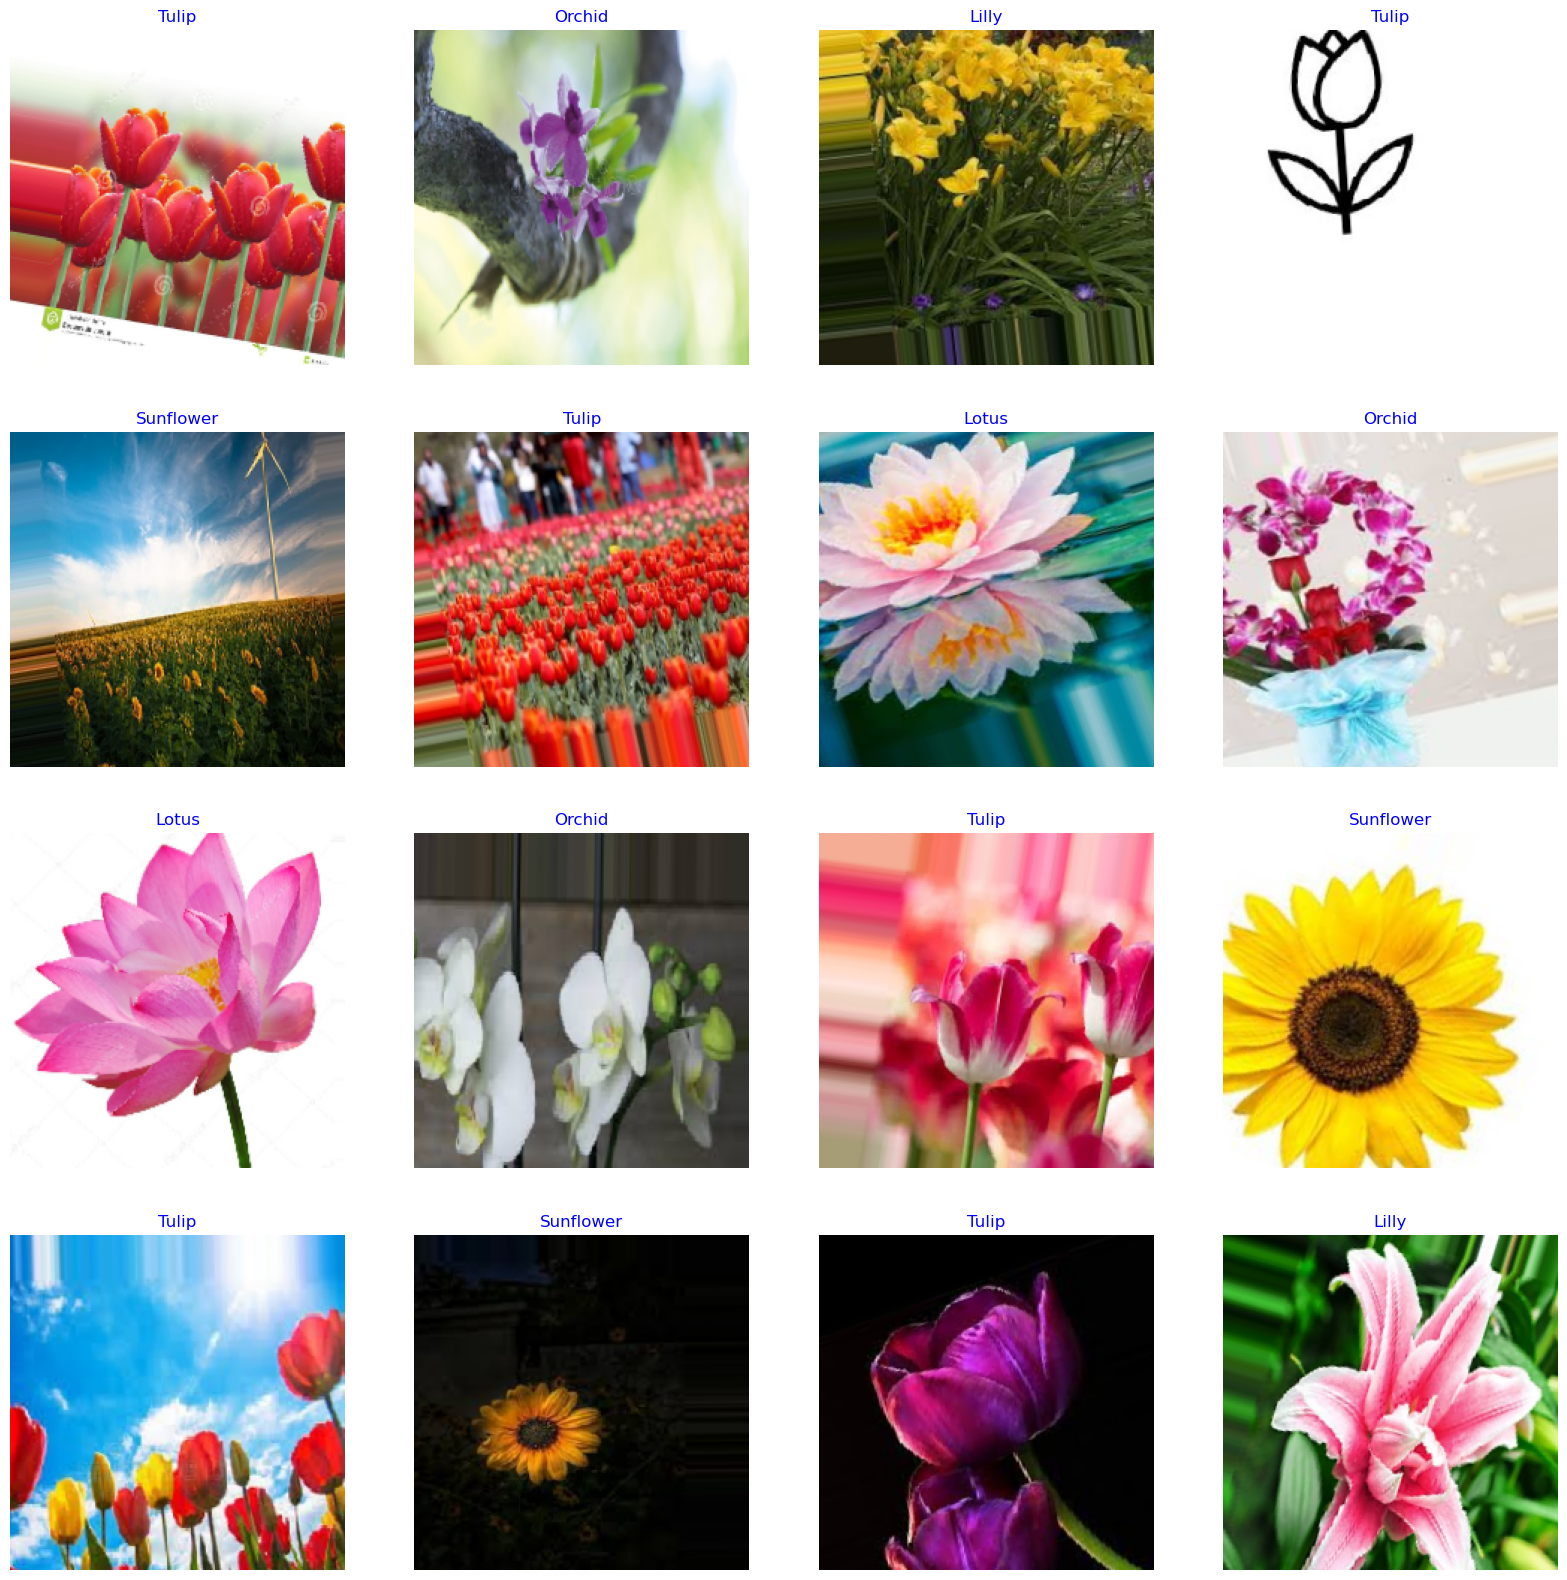

In [13]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Model Building

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
EfficientNet_model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

EfficientNet_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

EfficientNet_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_3 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 256)               393472    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 11,184,436
Trainable params: 11,094,061
Non-trainable params: 90,375
_____________________________________

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [26]:
batch_size = 16   # set batch size for training
epochs = 20   # number of all epochs in training

history = EfficientNet_model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False, callbacks=[early_stopping])

Epoch 1/20
250/250 [==============================] - 93s 369ms/step - loss: 7.0062 - accuracy: 0.7610 - val_loss: 5.4120 - val_accuracy: 0.9033
Epoch 2/20
250/250 [==============================] - 87s 349ms/step - loss: 4.4664 - accuracy: 0.8957 - val_loss: 3.6012 - val_accuracy: 0.9233
Epoch 3/20
250/250 [==============================] - 88s 351ms/step - loss: 3.0027 - accuracy: 0.9275 - val_loss: 2.4616 - val_accuracy: 0.9383
Epoch 4/20
250/250 [==============================] - 87s 346ms/step - loss: 2.0729 - accuracy: 0.9293 - val_loss: 1.6980 - val_accuracy: 0.9417
Epoch 5/20
250/250 [==============================] - 88s 350ms/step - loss: 1.4023 - accuracy: 0.9557 - val_loss: 1.1760 - val_accuracy: 0.9467
Epoch 6/20
250/250 [==============================] - 87s 349ms/step - loss: 0.9809 - accuracy: 0.9628 - val_loss: 0.8441 - val_accuracy: 0.9500
Epoch 7/20
250/250 [==============================] - 88s 350ms/step - loss: 0.7108 - accuracy: 0.9675 - val_loss: 0.6089 - val_ac

In [28]:
metrics=pd.DataFrame(EfficientNet_model.history.history)

# Evaluating Model

In [29]:
metrics

,loss,accuracy,val_loss,val_accuracy
0,7.006246,0.76100,5.411972,0.903333
1,4.466395,0.89575,3.601241,0.923333
2,3.002694,0.92750,2.461572,0.938333
3,2.072921,0.92925,1.698028,0.941667
4,1.402257,0.95575,1.176030,0.946667
5,0.980945,0.96275,0.844119,0.950000
6,0.710825,0.96750,0.608882,0.958333
7,0.540337,0.96850,0.520009,0.946667
8,0.427299,0.97125,0.446124,0.955000
9,0.371598,0.97325,0.396789,0.963333


Text(0, 0.5, 'Accuracy')

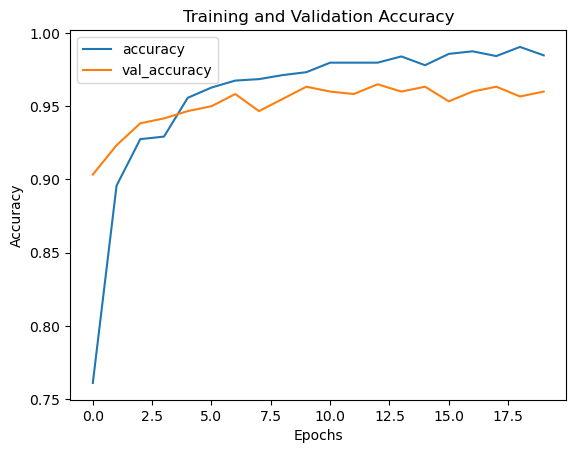

In [37]:
metrics[['accuracy','val_accuracy']].plot()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Loss')

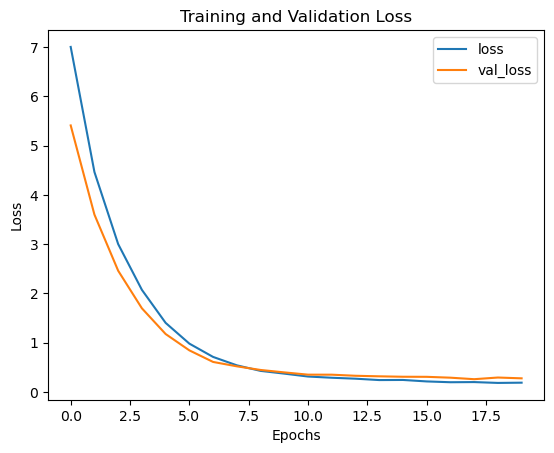

In [36]:
metrics[['loss','val_loss']].plot()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [39]:
preds = EfficientNet_model.predict_generator(testing_gen)
y_pred = np.argmax(preds, axis=1)

/tmp/ipykernel_28/3122503165.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = EfficientNet_model.predict_generator(testing_gen)


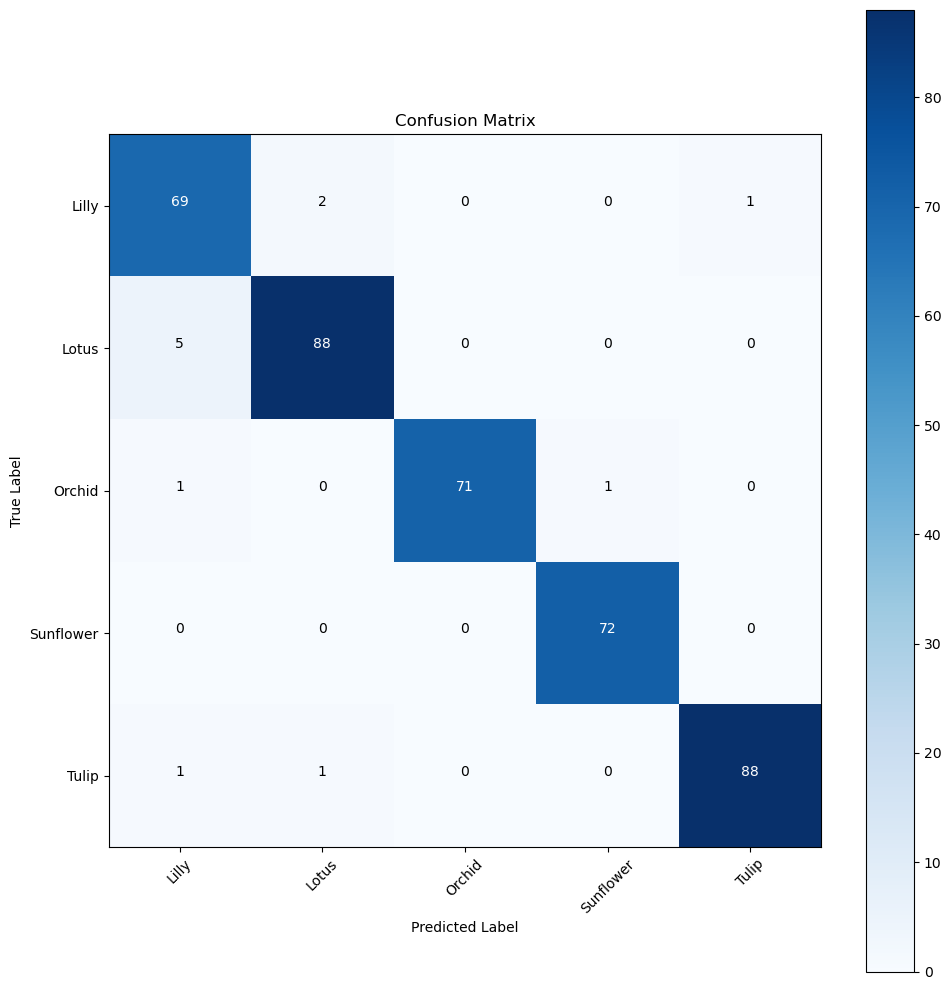

In [44]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report
g_dict = testing_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(testing_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [45]:
print(classification_report(testing_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       Lilly       0.91      0.96      0.93        72
       Lotus       0.97      0.95      0.96        93
      Orchid       1.00      0.97      0.99        73
   Sunflower       0.99      1.00      0.99        72
       Tulip       0.99      0.98      0.98        90

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



# Testing the model on random Image

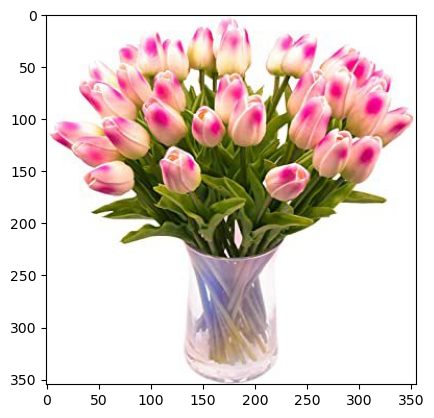

In [62]:
image_path = '/kaggle/input/5-flower-types-classification-dataset/flower_images/Tulip/009b4d16a9.jpg'
Tulip=plt.imread(image_path)
plt.imshow(Tulip)


In [63]:
# Convert the image to an array
Tulip_array = image.img_to_array(Tulip)

# Expand the dimensions of the array to match model input shape
Tulip_array_expanded = np.expand_dims(Tulip_array, axis=0)

# Preprocess the image array (optional, if needed)
Tulip_array_preprocessed = Tulip_array_expanded / 255.0  # Normalize pixel values

# Make predictions using the model
predictions = EfficientNet_model.predict(Tulip_array_preprocessed)
class_labels = classes
score = tf.nn.softmax(predictions[0])

predicted_class = class_labels[np.argmax(score)]
print(f"Predicted class: {predicted_class}")


1/1 [==============================] - 1s 600ms/step
Predicted class: Tulip
